# Arima

O ARIMA é um modelo poderoso para previsão de séries temporais, especialmente quando os dados mostram autocorrelações que podem ser capturadas pelos componentes AR e MA. Entender cada componente e como eles se combinam é essencial para construir modelos preditivos eficazes. Como com qualquer modelo estatístico, a seleção cuidadosa dos parâmetros e a consideração das limitações são cruciais para obter previsões confiáveis.

Admito que a fórmula pode ser exaustiva e bem circular, mas só vou deixar uma rápida explicação e te poupar dos cálculos e fórmulas

É uma ótima ferramenta a ser usada para Forecasting. Menos para séries estacionária, aqui aplicamos diferenciação para eliminar ou diminuir a tendência

Entender cada componente é essencial:

* AR (Autoregressivo) - Aqui você está dizendo: "Modelo, o valor de amanhã está bem relacionado com o(s) n último(s) dia(s)." É responsável pela autoregressão do modelo. AR = 2 significa, por exemplo, que a previsão atual depende da correlação com os últimos dois lags. É calculado pelo coeficiente autoregressivo (que pode ser encontrado pela fórmula de Yule-Walker usando os coeficientes de autocorrelação desses lags), multiplicado pelo valor diferenciado (se d = 1, então é a diferença entre o valor atual e o valor anterior). Quanto maior o valor de p, mais períodos passados influenciam o valor atual. Os resíduos do AR serão usados no modelo MA

* I (Diferenciação) - A diferenciação é usada para tornar a série temporal estacionária, eliminando tendências ou sazonalidades. Se a série não for estacionária, o modelo ARIMA pode ter dificuldades em capturar padrões corretamente. 

* MA (Média Móvel) - Aqui você está dizendo: "Modelo, o erro dessa previsão tem relação com o n último(s) dia(s)".  É responsável por atribuir pesos aos resíduos encontrados no modelo AR. O MA visa capturar a influência dos erros passados (resíduos) para melhorar as previsões futuras. Faz isso ajustando a previsão com base nos resíduos passados, procurando reduzir a autocorrelação dos resíduos. Aumentar q significa que resíduos mais antigos têm mais impacto e o melhor lag (o mais autocorrelacionado) ajuda o modelo a ajustar melhor as previsões futuras

Por fim, a previsão final é uma combinação dos componentes AR e MA aplicados aos dados diferenciados. 🫡

Portanto, note a importância: se sua série tiver correlações mais fortes com períodos mais distantes, usar valores menores de p e q pode impactar negativamente seu modelo, e vice-versa

Obs: Aqui usamos o dataset famoso airpassengers.csv, mas a nível didático são bons dados

*** Dica: forecast sempre leva como princípio que a previsão está errada (o mundo é aleatório demais), portanto sempre mostre sua previsão com intervalos de confiança, dê a margem de erro para que seu cliente se prepare melhor.*** 💭

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def dateparse(dates): return datetime.strptime(dates, '%Y-%m')


data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

C:\Users\Luis Henrique\AppData\Local\Temp\ipykernel_10472\1064921736.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)


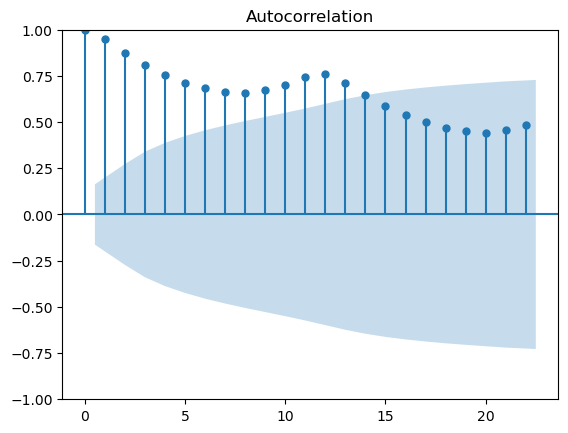

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data) #para parm q
plt.show()

Veja como temos a maior autocorr no lag 2, 3, assim por diante. Repare como ele faz uma onde e vai caindo a medida que aumentamos nosso lag

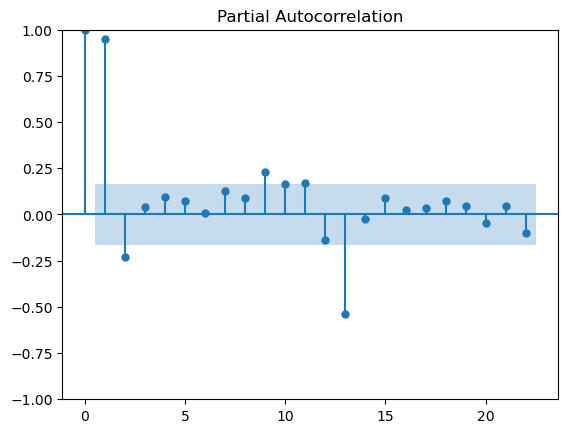

In [4]:
plot_pacf(data, method='ywm') #para parm p
plt.show()

Aqui, poderíamos decidir entre lag 2 e 12-13, sendo o segundo lag o mais forte

In [5]:
from statsmodels.tsa.arima.model import ARIMA # arima não lê efeitos sazonais, então não podemos esperar um bom modelo visto que os dados possuem

In [8]:
data.index.freq = 'MS'
modelo = ARIMA(data, order=(2,1,2)) #p = 2 e q =2. Diferenciamos nossos dados vistos que o airpassengers possuí tendência
model_fit = modelo.fit()

print(model_fit.summary())
#no summary, sempre se atente ao AIC e BIC além dos erros padrões dos coef (eles são importantes para a previsão e aplicabilidade, precisam estar próximos de 0)

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Mon, 26 Aug 2024   AIC                           1353.347
Time:                        15:47:37   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.819      0.0

c:\Users\Luis Henrique\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


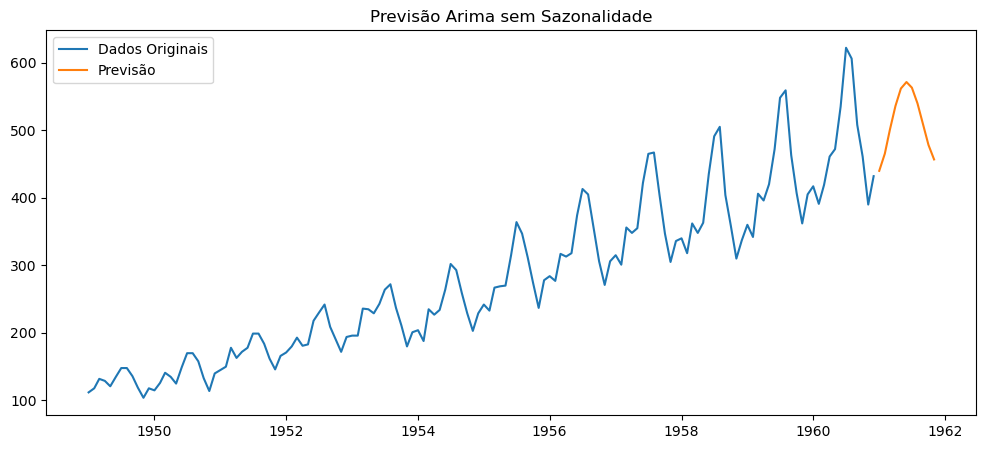

In [7]:
n_periods = 12
forecast = model_fit.forecast(steps=n_periods)
idx = pd.date_range(data.index[-1], periods=n_periods, freq='MS')
forecast_series = pd.Series(forecast, index=idx)
plt.figure(figsize=(12,5))
plt.plot(data, label='Dados Originais')
plt.plot(forecast_series, label='Previsão')
plt.title('Previsão Arima sem Sazonalidade')
plt.legend()
plt.show()

# Arima com sazonalidade

Modelos arimas básicos não capturam sazonalidade, por isso em modelo com a Sazonalidade precisamos capturá-la no modelo também. Também passamos parâmetros AR, I e MA para a sazonalidade sozinha, por isso em séries temporais com sazonalidade precisam ser bem analisadas. 

Aqui usamos o SARIMAX(P, D, Q, M) -> M aqui é o período sazonal, se estamos criando uma série temporal anual, 12 siginifica 12 anos, se meses, 12 meses, se dias 12 dias e assim por diante

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
model = SARIMAX(data, order=(2,1,2), seasonal_order=(2,1,0,12)) #aqui colocamos nossos dados de sazonalidade em seasonal_order(P, D, Q, m) - inicamos com 2,1,0 mas poderíamos plotar 
#acf e pacf dos dados decompostos e procurar bons valores
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 26 Aug 2024   AIC                           1019.178
Time:                                     15:48:04   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

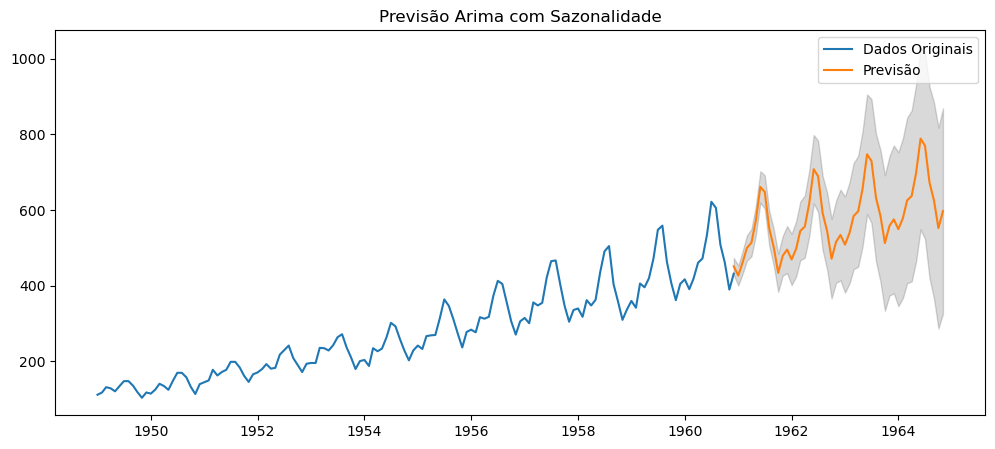

In [11]:

n_periods = 48
forecast_results = model_fit.get_forecast(steps=n_periods)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()
idx = pd.date_range(data.index[-1], periods=n_periods, freq='MS')

plt.figure(figsize=(12,5))
plt.plot(data, label='Dados Originais')
plt.plot(idx, forecast, label='Previsão')
plt.fill_between(idx, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)
plt.title('Previsão Arima com Sazonalidade')
plt.legend()
plt.show()

# Auto Arima

Um modelo de maior custo computacional, porém melhor já que você pode iniciar seu Arima com parâmetros baixos e o Auto Arima vai testando, exaustivamente, diversos modelos com diversos parâmetros que reduzem os erros e encontrar o melhor modelo para uso. Porém, esse modelo não te permite manipular ele com tanta facilidade. Modelos como Arima ou Sarimax, te permitem moldar o modelo a sua forma</br>

Nem sempre modelos com os menores erros são os melhores, lembre-se disso

AutoArima é um excelente modelo para uma primeira exploração do ARIMA

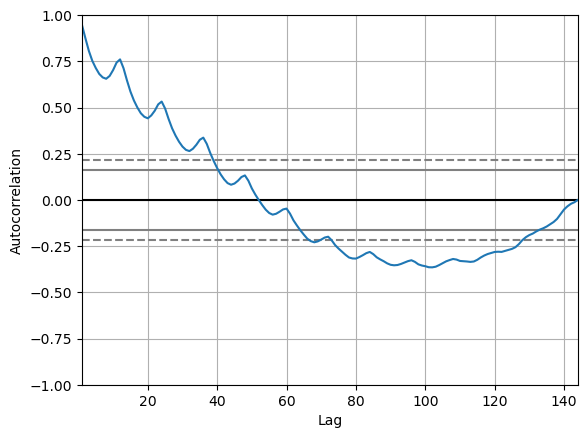

In [12]:
from pandas.plotting import autocorrelation_plot #um bom plot de autocorrelação de lags

autocorrelation_plot(data)
plt.show()

In [13]:
from pmdarima.arima import auto_arima

In [14]:
stepwise_model = auto_arima(data, start_p=1, start_q=0, max_p=6, max_q=6, m=12, 
                            start_P=0, start_Q=0, seasonal=True, d=1, D=1, 
                            error_action='ignore', 
                            suppress_warnings=True, stepwise=True) #iniciando o modelo com p = 1, q = 0, e P = 0 e Q = 0, diferenciando tanto a série quando a sazonalidade d, D = 1
#param seasonal = True (para aplicar sazonalidade)

In [15]:
print(stepwise_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 26 Aug 2024   AIC                           1019.178
Time:                                     15:51:01   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

Desta vez vamos separar dados entre treino e teste para testarmos algumas métricas de desempenho

In [16]:
train = data.loc['1948-01-01':'1959-12-01']
test = data.loc['1960-01-01':]

In [17]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [18]:
future_forecast = stepwise_model.predict(n_periods=12)

future_forecast = pd.DataFrame(future_forecast, index= test.index, columns=["#Passengers"])

In [19]:
real_values = np.array([test['#Passengers']])
predicted_values = np.array([future_forecast['#Passengers']])

# Calcular APE para cada ponto
ape = np.abs((real_values - predicted_values) / real_values) * 100 #metrica de desempenho APE

precision = 100 - ape

print(precision.mean())

96.84678479445472


<Figure size 1000x800 with 0 Axes>

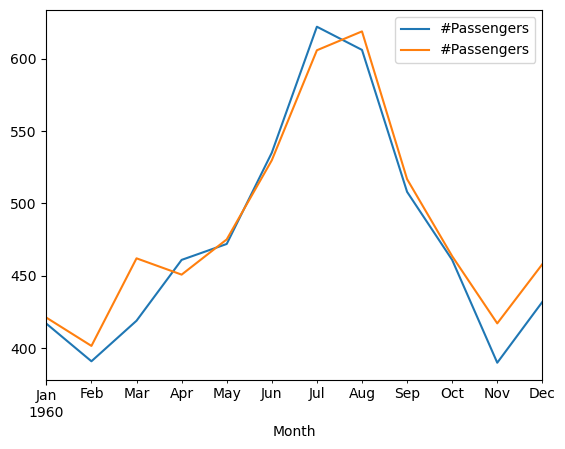

In [20]:
plt.figure(figsize=(10,8))
pd.concat([test, future_forecast], axis=1).plot()
plt.show() #vamos ver dentre do ultimo ano a previsao e o real

<Figure size 1000x800 with 0 Axes>

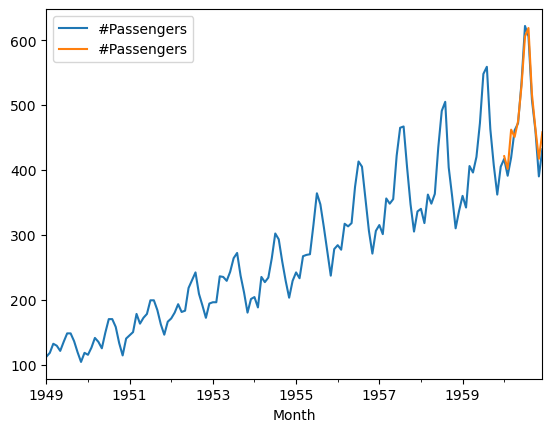

In [21]:
plt.figure(figsize=(10,8))
pd.concat([data, future_forecast], axis=1).plot()
plt.show()

<Axes: ylabel='Count'>

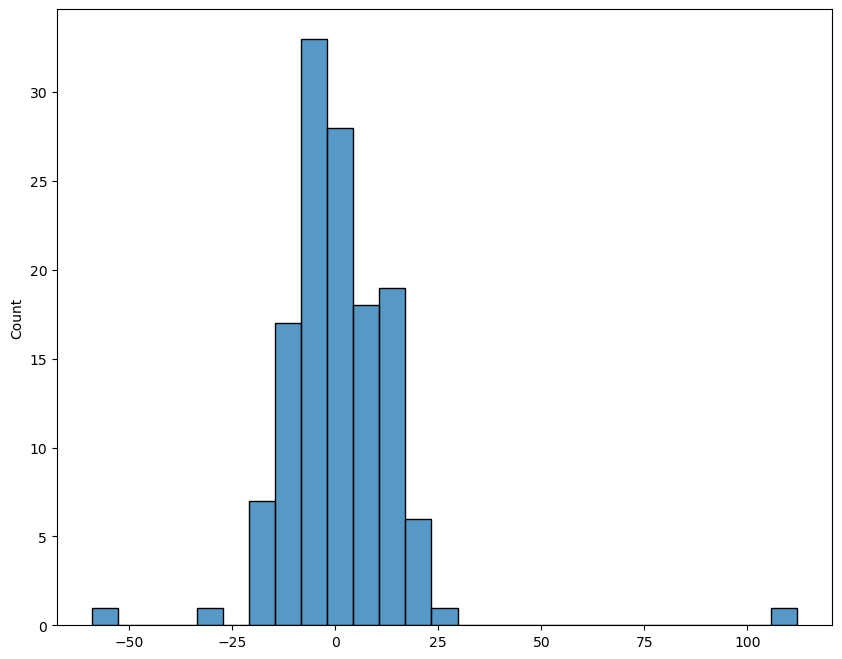

In [22]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.histplot(stepwise_model.resid())

<Axes: xlabel='Month'>

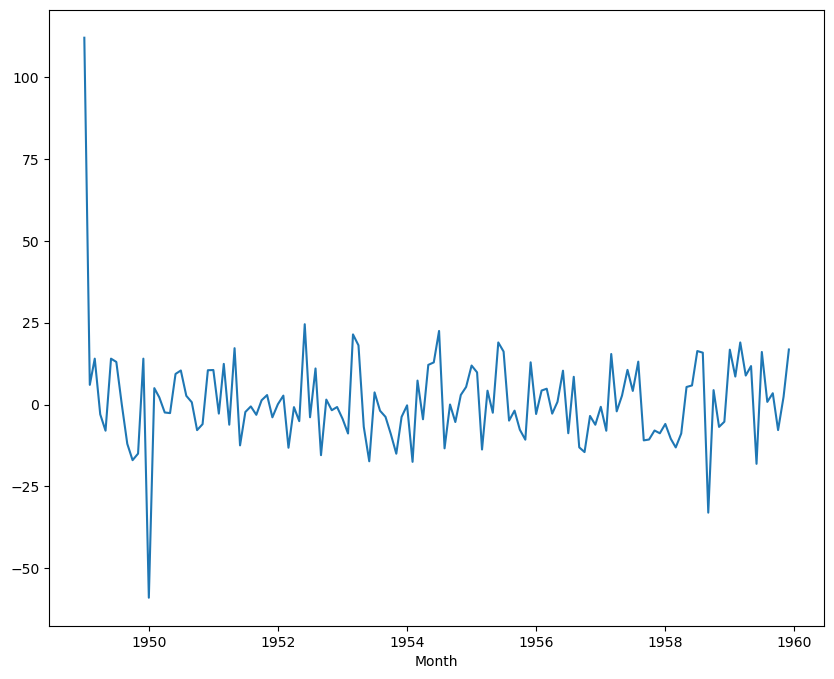

In [23]:
plt.figure(figsize=(10,8))
sns.lineplot(stepwise_model.resid())

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

future_forecast = stepwise_model.predict(n_periods=12)

mae_arima = mean_absolute_error(test, future_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, future_forecast))
mape_arima = mean_absolute_percentage_error(test, future_forecast)

print(f'MAE: {mae_arima:.2F}')
print(f'RMSE: {rmse_arima:.2F}')
print(f'MAPE: {mape_arima:.2%}')

MAE: 14.16
RMSE: 18.38
MAPE: 3.15%


Nossos resíduos não podem estar autocorrelacionados

In [29]:
from statsmodels.tsa.stattools import adfuller

def adf_test(y):
    print('Resultado do teste: ')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Teste', 'Valor p', '# de lags', "# de observações"])
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos ({})'.format(key)] = value
    print(dfoutput)


adf_test(stepwise_model.resid())

Resultado do teste: 
Teste                    -1.488254e+01
Valor p                   1.601321e-27
# de lags                 0.000000e+00
# de observações          1.310000e+02
Valores Críticos (1%)    -3.481282e+00
Valores Críticos (5%)    -2.883868e+00
Valores Críticos (10%)   -2.578677e+00
dtype: float64


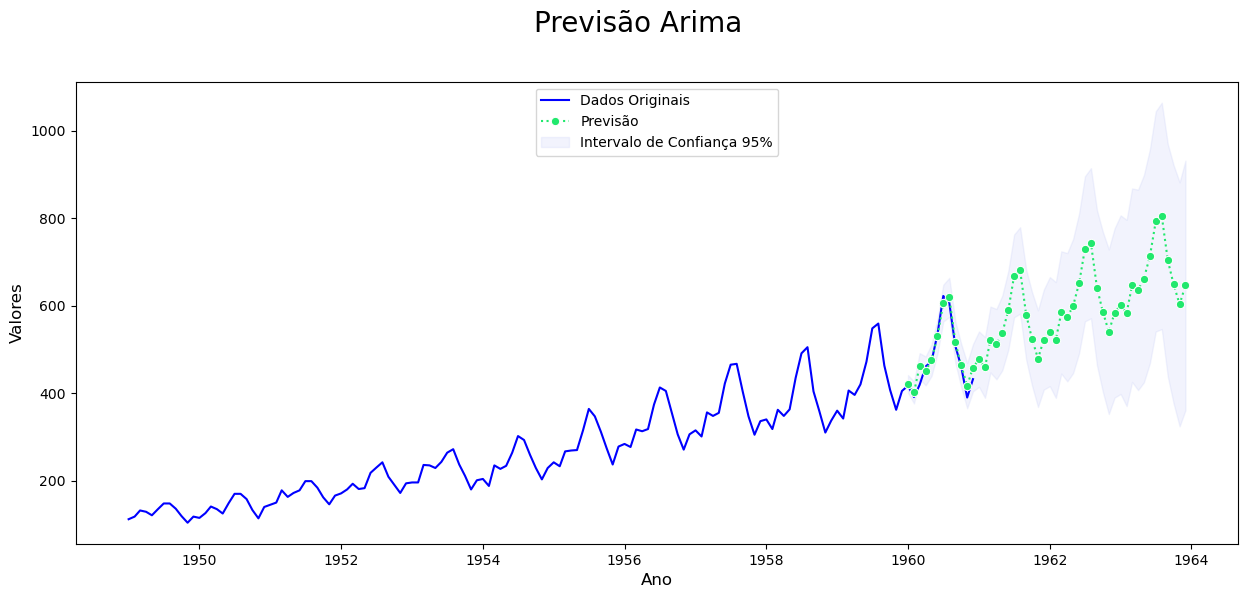

In [ ]:

future_forecast, conf_int = stepwise_model.predict(n_periods=48, return_conf_int=True)
future_forecast = pd.DataFrame(future_forecast,  columns=["#Passengers"])
future_forecast['Menor'] = conf_int[:, 0]
future_forecast['Maior'] = conf_int[:, 1]

plt.figure(figsize=(15,6))
sns.lineplot(data['#Passengers'], 
             label='Dados Originais', 
             linestyle='-', color='b')
sns.lineplot(future_forecast['#Passengers'], 
             label='Previsão', 
             linestyle='dotted', marker='o', color='#21E86D')
plt.fill_between(future_forecast.index, 
                 future_forecast['Menor'], future_forecast['Maior'], 
                 color='#A9B2F3', alpha=0.15, label='Intervalo de Confiança 95%')
plt.suptitle('Previsão Arima', 
             fontsize=20, x=0.5, y=1)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(loc='upper center')
plt.show()